In [1]:
# MIT License

# Copyright (c) 2017 Johannes Dollinger

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# https://github.com/emulbreh/bridson

from random import random
from math import cos, sin, floor, sqrt, pi, ceil

def euclidean_distance(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return sqrt(dx * dx + dy * dy)

def poisson_disc_samples(width, height, r, k=5, distance=euclidean_distance, random=random):
    tau = 2 * pi
    cellsize = r / sqrt(2)

    grid_width = int(ceil(width / cellsize))
    grid_height = int(ceil(height / cellsize))
    grid = [None] * (grid_width * grid_height)

    def grid_coords(p):
        return int(floor(p[0] / cellsize)), int(floor(p[1] / cellsize))

    def fits(p, gx, gy):
        yrange = list(range(max(gy - 2, 0), min(gy + 3, grid_height)))
        for x in range(max(gx - 2, 0), min(gx + 3, grid_width)):
            for y in yrange:
                g = grid[x + y * grid_width]
                if g is None:
                    continue
                if distance(p, g) <= r:
                    return False
        return True

    p = width * random(), height * random()
    queue = [p]
    grid_x, grid_y = grid_coords(p)
    grid[grid_x + grid_y * grid_width] = p

    while queue:
        qi = int(random() * len(queue))
        qx, qy = queue[qi]
        queue[qi] = queue[-1]
        queue.pop()
        for _ in range(k):
            alpha = tau * random()
            d = r * sqrt(3 * random() + 1)
            px = qx + d * cos(alpha)
            py = qy + d * sin(alpha)
            if not (0 <= px < width and 0 <= py < height):
                continue
            p = (px, py)
            grid_x, grid_y = grid_coords(p)
            if not fits(p, grid_x, grid_y):
                continue
            queue.append(p)
            grid[grid_x + grid_y * grid_width] = p
    return [p for p in grid if p is not None]

result = poisson_disc_samples(6000, 6000, 350, k=5)
len(result)
#result

148

In [2]:
import random

from geopy.distance import geodesic

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.weight': 'bold'})

In [3]:
import random
import kdtree
import sys
from math import cos, sin, floor, sqrt, pi, ceil, radians, atan2, degrees

debug = False

def saveNedFile(fileName, networkName, nodeMap, mapHeightM):
    template = open("nedGenTemplate.txt", "r")
    templateTxt = template.read()
    templateTxt = templateTxt.replace('##{NETWORK_NAME}##', networkName)
    templateTxt = templateTxt.replace('##{BGB}##', str(mapHeightM) + ',' + str(mapHeightM))
    
    df = pd.DataFrame(data=reversed(nodeMap))
    maximum_x_value = df['x'].max()
    minimum_x_value = df['x'].min()
    maximum_y_value = df['y'].max()
    minimum_y_value = df['y'].min()
    
    scale = 1
    
    nodesStr = ''
    i = 1
    for node in nodeMap:
        nodeText = '\n    sensors_' + str(i) + ': MobileSensorNode {'
        nodeText = nodeText + '\n        @display("i=misc/sensor;p=' + "{:.2f}".format((node['x'])*scale) + ',' + "{:.2f}".format((mapHeightM - node['y'])*scale) + '");'
        nodeText = nodeText + '\n    }\n'
        nodesStr = nodesStr + nodeText
        i = i + 1
    
    templateTxt = templateTxt.replace('##{NODES}##', nodesStr)
    
    f = open(fileName, "w")
    f.write(templateTxt)
    f.close()

# Translate from iniLat,iniLon to a new latitude adding the (x,y) points.
def toLatLon(iniLat, iniLon, x, y):
    # Base latitude and longitude
    base_latitude = radians(iniLat)
    base_longitude = radians(iniLon)
    
    # Earth's radius in meters
    earth_radius = 6371000  # approximately 6371 km
    
    # Calculate the latitude difference per meter
    lat_diff_per_meter = 1 / earth_radius
    
    # Calculate the longitude difference per meter at the given latitude
    lon_diff_per_meter = 1 / (earth_radius * cos(base_latitude))

    # Convert meters to latitude and longitude offsets
    lat = base_latitude + x * lat_diff_per_meter
    lon = base_longitude + y * lon_diff_per_meter

    return degrees(lat), degrees(lon)

def saveIniFile(networkNames, nodeMaps, nUAVsMap):
    template = open("iniGenTemplate.txt", "r")
    templateTxt = template.read()
    
    output = open("dadcaAckSim.ini", "w")
    
    fileContent = ''
    
    for networkName in networkNames:
        templateTxtTemp = templateTxt
        templateTxtTemp = templateTxtTemp.replace('##{NETWORK_NAME}##', networkName)

        nodeMap = nodeMaps[networkName]
        nodePositionsIniStr = ''

        nUAVs = nUAVsMap[networkName]
        nodePositionsIniStr += '*.numUAVs = ' + str(nUAVs) + '\n\n'
        
        sensorI = 1
        
        iniLat = -15.8401
        iniLon = -47.9266
    
        for node in nodeMap:
            lat, lon = toLatLon(iniLat, iniLon, node['x'], node['y'])

            nodePositionsIniStr += '*.sensors_' + str(sensorI) + '.mobility.initialLatitude = %.8fdeg\n'%lat
            nodePositionsIniStr += '*.sensors_' + str(sensorI) + '.mobility.initialLongitude = %.8fdeg\n'%lon
            sensorI = sensorI + 1

        nodePositionsIniStr += '\n'
        
        nSensors = len(nodeMap)

        sensorAddr = '*.sensors*.app[0].destAddresses = "'
        gsAddr = '*.groundStation.app[0].destAddresses = "'
        for i in range(nUAVs):
            sensorAddr += 'quads[' + str(i) + ']'
            gsAddr += 'quads[' + str(i) + ']'
            if i < nUAVs - 1:
                sensorAddr += ' '
                gsAddr += ' '
        sensorAddr += '"\n'
        gsAddr += '"\n'
        nodePositionsIniStr += sensorAddr
        nodePositionsIniStr += gsAddr
            
        for i in range(nUAVs):
            addr = '*.quads[' + str(i) + '].app[0].destAddresses = "'
            for j in range(nUAVs):
                if i == j:
                    continue
                addr += 'quads[' + str(j) + '] '
            for j in range(nSensors):
                addr += 'sensors_' + str(j+1) + ' '
            addr += 'groundStation"\n'
            #print(addr)
            nodePositionsIniStr += addr
        
        nodePositionsIniStr += '\n\n'
        
        for i in range(nUAVs):
            sec = 40 * i
            appSec = 40 * i
            if (appSec == 0):
                appSec = 1
            nodePositionsIniStr += '*.quads[' + str(i) + '].app[*].startTime = normal(' + str(appSec) + 's, ' + str(appSec + 5) + 's)\n'
            nodePositionsIniStr += '*.quads[' + str(i) + '].mobility.startTime = ' + str(sec) + 's\n'

        gsStartTime = 40 * nUAVs
        
        nodePositionsIniStr += '*.groundStation.app[0].startTime = ' + str(gsStartTime) + 's\n\n'

        nodePositionsIniStr += '*.quads[*].mobility.waypointFile = "paths/gen/tempAutoRouteUav' + networkName + '--sx--0.waypoints"'
        
        # Add node positions
        templateTxtTemp = templateTxtTemp.replace('##{S1-END}##', nodePositionsIniStr.replace('--sx--','--s1--'))
        templateTxtTemp = templateTxtTemp.replace('##{S2-END}##', nodePositionsIniStr.replace('--sx--','--s2--'))
        
        fileContent = fileContent + templateTxtTemp
    
    appendedIni = open("omnetpp.ini", "r")
    fileContent = fileContent + appendedIni.read()
    appendedIni.close()
    
    output.write(fileContent)
    output.close()

def dist2(p1,p2):
    return sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

# This class emulates a tuple, but contains a useful payload
class Item(object):
    def __init__(self, x, y, data):
        self.coords = (x, y)
        self.data = data

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, i):
        return self.coords[i]

    def __repr__(self):
        return 'Item({}, {}, {})'.format(self.coords[0], self.coords[1], self.data)

def genMap(mapWidthM, mapHeightM, nodeCount, minDistanceM):
    
    print(str(nodeCount) + ' nodes.')

    retries = 4

    i = 0
    while retries > 0:
        poissonResult = poisson_disc_samples(6000, 6000, 350, k=5)
    
        nodeMap = []
    
        i = 0
        for node in poissonResult:
            if i >= nodeCount:
                break
                
            nodeMap.append({
                'x': node[0],
                'y': node[1],
                'mode': 'default'
            })
            i += 1
    
        if i != nodeCount:
            retries -= 1
            continue
                
        return nodeMap
    
    sys.exit('Error, i does not match node count. Exiting.')

def latLonDist(lat1, lon1, lat2, lon2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    # Approximate radius of earth in km
    R = 6373.0
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distanceKm = R * c
    distanceM = distanceKm * 1000
    
    print("Result: ", distanceM)
    return distanceM

In [4]:
iniLat = -15.8401
iniLon = -47.9266

x0 = 0
y0 = 0

x1 = 150
y1 = 250

print("Distance in meters (x,y): %.2f" % dist2([x0,y0],[x1,y1]))

lat1, lon1 = toLatLon(iniLat, iniLon, x0, y0)

lat2, lon2 = toLatLon(iniLat, iniLon, x1, y1)

print("1=(%.6f, %.6f) 2=(%.6f, %.6f)" % (lat1, lon1, lat2, lon2))
latLonDist(lat1, lon1, lat2, lon2)

Distance in meters (x,y): 291.55
1=(-15.840100, -47.926600) 2=(-15.838751, -47.924263)
Result:  291.6398343048049


291.6398343048049

20 nodes.


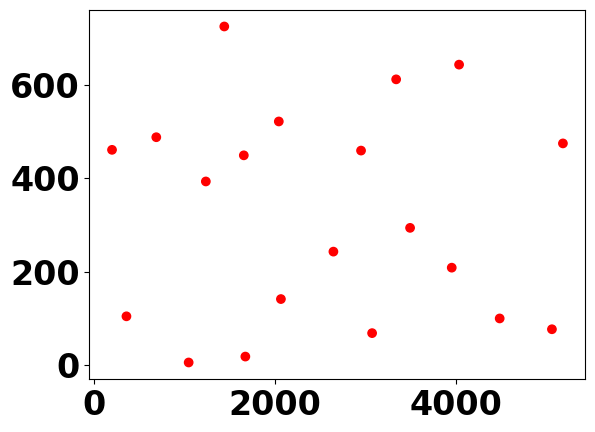

50 nodes.


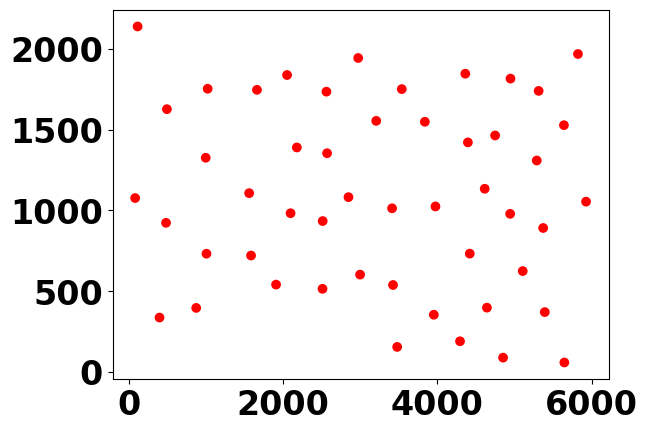

100 nodes.


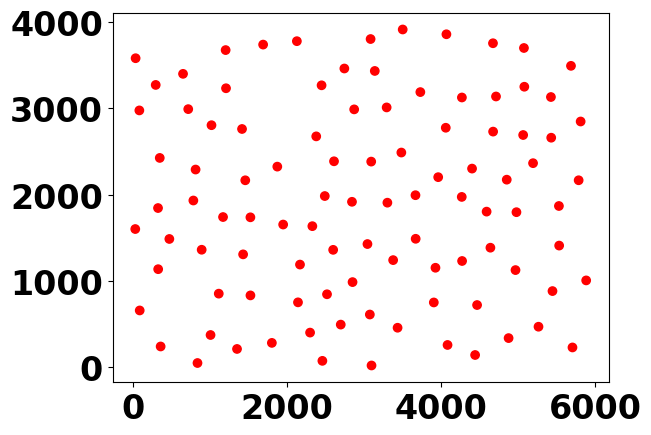

20 nodes.


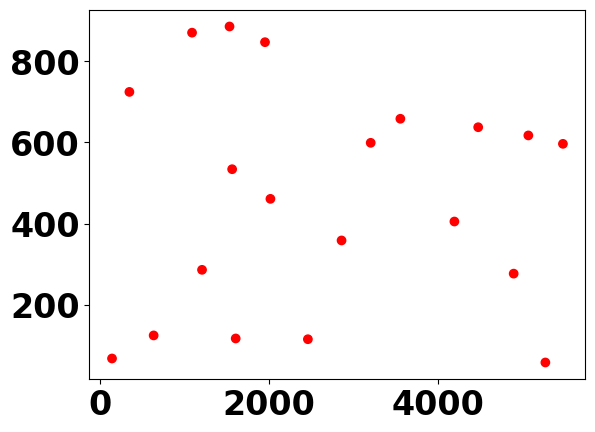

50 nodes.


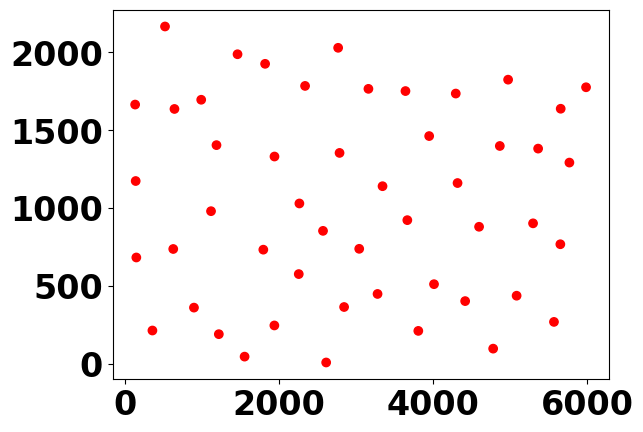

100 nodes.


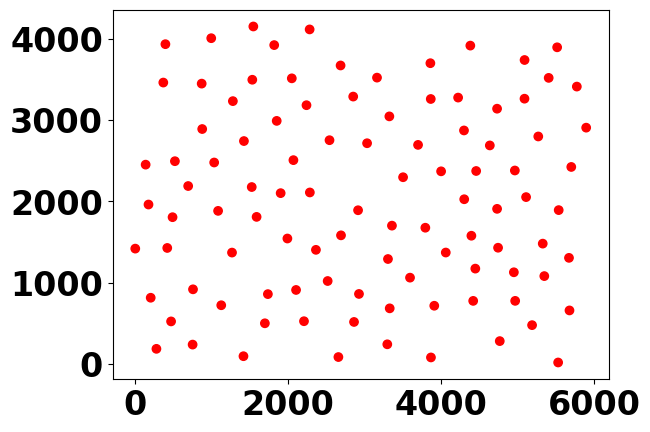

20 nodes.


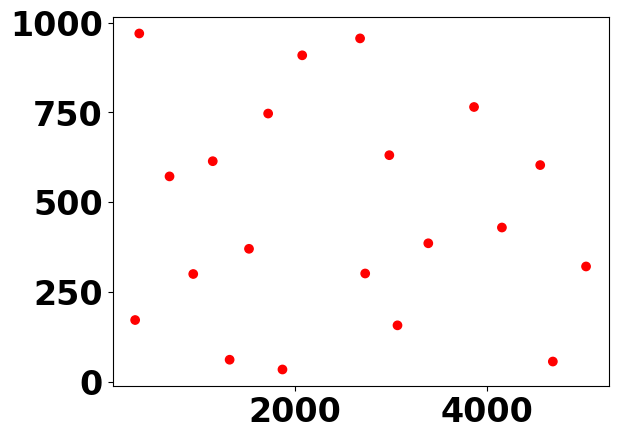

50 nodes.


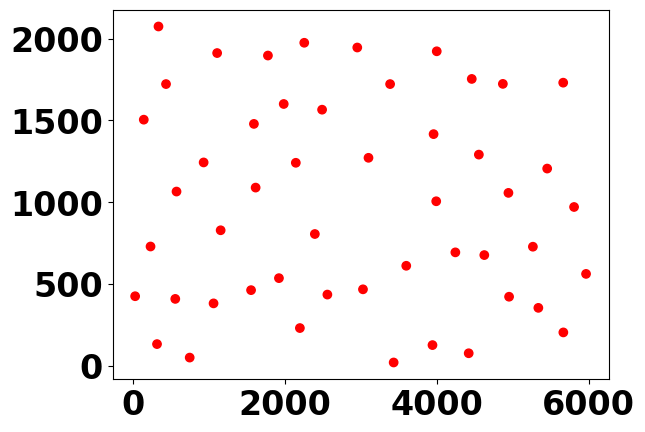

100 nodes.


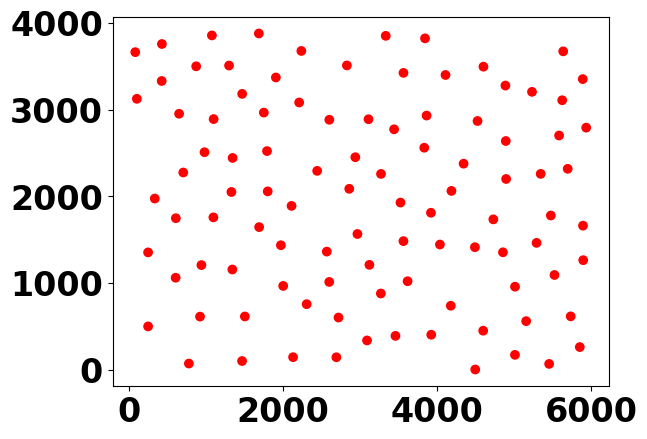

20 nodes.


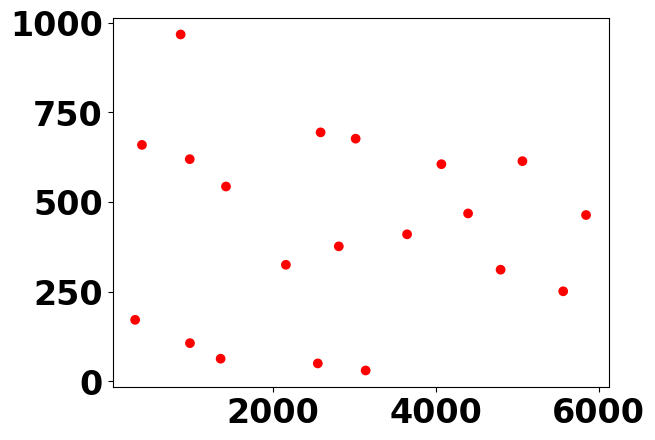

50 nodes.
100 nodes.
20 nodes.
50 nodes.
100 nodes.


In [5]:
mapAreas = [8000]

nUAVsOptions = [2,3,4,8,16]
nodeCounts = [20,50,100]

minDistanceM = 60

genTimes = 1 # change to 10 for 10 repetitions

def runGen():
    networkMapNames = []
    nodeMaps = {}
    nUAVsMap = {}

    genPreviewLimit = 10
    
    for mapArea in mapAreas:
        mapWidthM = mapArea
        mapHeightM = mapArea

        for nUAVs in nUAVsOptions:
            for nodeCount in nodeCounts:
                
                for i in range (0, genTimes):
                    nodeMap = genMap(mapWidthM, mapHeightM, nodeCount, minDistanceM)
                    
                    if debug:
                        for i in range(0, len(nodeMap)):
                            for j in range(0, len(nodeMap)):
                                if i == j:
                                    continue
                                dist = sqrt( (nodeMap[i]['x'] - nodeMap[j]['x'])**2 + (nodeMap[i]['y'] - nodeMap[j]['y'])**2 )
                                if dist < minDistanceM:
                                    print('ERROR - dist=' + str(dist))
    
    
                    networkMapName = 'DADCA_ACK_n' + str(nodeCount) + '_u' + str(nUAVs) + '_a' + str(mapArea) + 'm2_' + str(i)
                    networkMapNames.append(networkMapName)
                    nUAVsMap[networkMapName] = nUAVs
                    nodeMaps[networkMapName] = nodeMap
                    saveNedFile(networkMapName + '.ned', networkMapName, nodeMap, mapHeightM)
                    df = pd.DataFrame(data=reversed(nodeMap))
                    colors = {'default':'red'}

                    if genPreviewLimit > 0:
                        plt.scatter(df['x'], df['y'], c=df['mode'].map(colors))
                        plt.show()
                        genPreviewLimit -= 1
        
    saveIniFile(networkMapNames, nodeMaps, nUAVsMap)
    
runGen()